<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=250 ALIGN="right">
</figure>

# MORE group project
*WIM-data analysis*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
import matplotlib.gridspec as gridspec
from scipy import stats
import pyvinecopulib as pv
from scipy.stats import rankdata

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.d_cal import test_distance
from py_banshee.copula_test import cvm_statistic
from py_banshee.prediction import inference,conditional_margins_hist
from py_banshee.sample_bn import generate_samples
import pyvinecopulib as pv
import networkx as nx

In [2]:
# List of axle load columns
axle_load_columns = [
    'axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]', 'axle 4 [kg]', 'axle 5 [kg]', 
    'axle 6 [kg]', 'axle 7 [kg]', 'axle 8 [kg]', 'axle 9 [kg]', 'axle 10 [kg]', 
    'axle 11 [kg]', 'axle 12 [kg]', 'axle 13 [kg]', 'axle 14 [kg]'
]

# List of spacing columns
spacing_columns = [
    'ax1 - ax2 [cm]', 'ax2 - ax3 [cm]', 'ax3 - ax4 [cm]', 'ax4 - ax5 [cm]', 
    'ax6 - ax7 [cm]', 'ax7 - ax8 [cm]', 'ax8 - ax9 [cm]', 'ax10 - ax11 [cm]', 
    'ax11 - ax12 [cm]', 'ax12 - ax13 [cm]', 'ax13 - ax14 [cm]'
]

## Importing data

In [3]:
%%capture
# Importing data and combining in 1 large dataframe
data_left = pd.read_csv('DATA_RW_12L_April2013.csv', delimiter=';', skipinitialspace=True, index_col=False);
data_right = pd.read_csv('DATA_RW_12R_April2013.csv', delimiter=';', skipinitialspace=True, index_col=False);
combined_data = pd.concat([data_left, data_right], ignore_index=True)

# Some renaming of columns and adding of new columns to make things easier
combined_data.rename(columns={'ax3- ax4 [cm]': 'ax3 - ax4 [cm]'}, inplace=True)
combined_data['wheelbase [cm]'] = combined_data[spacing_columns].sum(axis=1)
combined_data['number_of_axles'] = combined_data[axle_load_columns].count(axis=1)

In [4]:
combined_data.head()

,date,time,ID,lane,subcat,velocity [km/h],length [cm],mass [kg],axle 1 [kg],axle 2 [kg],...,ax4 - ax5 [cm],ax6 - ax7 [cm],ax7 - ax8 [cm],ax8 - ax9 [cm],ax10 - ax11 [cm],ax11 - ax12 [cm],ax12 - ax13 [cm],ax13 - ax14 [cm],wheelbase [cm],number_of_axles
0,01-Apr-2013,06:29:29,24516576,RW-12-L-2,T11O3,87,1716,15694,5392,4506,...,132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1226.0,5
1,01-Apr-2013,06:45:35,24516659,RW-12-L-2,T11O3,84,1565,15024,5310,4242,...,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1261.0,5
2,01-Apr-2013,07:08:57,24516768,RW-12-L-2,V112,105,1158,8750,1428,2270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,855.0,4
3,01-Apr-2013,07:34:19,24516902,RW-12-L-2,T11O3,88,1693,18391,6216,4764,...,133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1208.0,5
4,01-Apr-2013,07:49:12,24516995,RW-12-L-2,B12,101,1318,19375,7209,8221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,813.0,3


## Cleaning data with filters

In [5]:
# Condition 1: Wheelbase < 1 meter
condition_1 = combined_data['wheelbase [cm]'] < 100  

# Condition 2: Wheelbase < 30m and spacing > 10m
condition_2 = (combined_data['wheelbase [cm]'] < 3000) & ((combined_data['ax1 - ax2 [cm]'] > 1000) | (combined_data['ax13 - ax14 [cm]'] > 1000))

# Condition 3: Wheelbase > 40 meters
condition_3 = combined_data['wheelbase [cm]'] > 4000  

# Condition 4: Axle load <= 0 tons
condition_4 = (combined_data[axle_load_columns].le(0)).any(axis=1)

# Condition 5: Axle load > 40 tons
condition_5 = (combined_data[axle_load_columns].gt(40000)).any(axis=1)

# Condition 6: Axle weight > 15 tons and > 85% of gross vehicle weight
condition_6 = (combined_data[axle_load_columns].max(axis=1) > 15000) & (combined_data[axle_load_columns].max(axis=1) / combined_data['mass [kg]'] > 0.85)

# Condition 7: Gross vehicle weight <= 0 tons
condition_7 = combined_data['mass [kg]'] <= 0  

# Condition 8: Sum of axle loads not within 50kg of gross vehicle weight
sum_axle_loads = combined_data[axle_load_columns].sum(axis=1)
condition_8 = (abs(sum_axle_loads - combined_data['mass [kg]']) > 50)

# Condition 9: less or equal to 2 m first two axles, one of which is larger than 10 tons and over 2.5 times heavier than other axle.
closely_spaced = combined_data['ax1 - ax2 [cm]'] <= 200
axle1_load = combined_data['axle 1 [kg]']
axle2_load = combined_data['axle 2 [kg]']
one_axle_heavy = (axle1_load > 10000) | (axle2_load > 10000)
axle_weight_ratio = (axle1_load / axle2_load > 2.5) | (axle2_load / axle1_load > 2.5)
condition_9 = closely_spaced & one_axle_heavy & axle_weight_ratio

# Condition 10: First spacing between the first two axles larger than 15m
condition_10 = combined_data['ax1 - ax2 [cm]'] > 1500  

# Condition 11: Any spacing less than 0.4 meters
condition_11 = combined_data[spacing_columns].min(axis=1) < 40  # Less than 0.4 meters

# Condition 12: Mismatch between number of axle spacings and number of axle loads
condition_12 = combined_data[axle_load_columns].count(axis=1) != (combined_data[spacing_columns].count(axis=1) + 1)

## Condition 13: Sum of axle spacings not within 50 mm of wheelbase.
## Unfortunately, we didn't have a seperate column for wheelbase in our csv file, so we cant do this calculation. We just added one ourselfs by summing the axle spacing, so comparing them would result in zero difference for all vehicles.

#Condition 14: Number of axles below or equal to 1.
condition_14 = combined_data[axle_load_columns].count(axis=1) <= 1

#Condition 15: First axle spacing in the interval of 10 m–15 m.
condition_15 = (combined_data['ax1 - ax2 [cm]'] >= 1000) & (combined_data['ax1 - ax2 [cm]'] <= 1500)

#Condition 16: 16.	Each spacing in range of 0,4 m–0,7 m.
condition_16 = combined_data[spacing_columns].ge(40).all(axis=1) & combined_data[spacing_columns].lt(70).all(axis=1)

#Condition 17: Each spacing in range of 0,7 m–1,0 m.
condition_17 = combined_data[spacing_columns].ge(70).all(axis=1) & combined_data[spacing_columns].lt(100).all(axis=1)

#Condition 18: Each axle load in the interval of 25 tons–40 tons.
condition_18 = combined_data[axle_load_columns].ge(25000).all(axis=1) & combined_data[axle_load_columns].lt(40000).all(axis=1)

#Condition 19: Each axle load below 0,5 tons.
condition_19 = combined_data[axle_load_columns].lt(500).all(axis=1)

#Condition 20: Vehicles with same WIM identification number (ID).
condition_20 = combined_data.duplicated(subset='ID', keep=False)

#Condition 21: Vehicles with a gross vehicle weight below 3,56 tons.
condition_21 = combined_data['mass [kg]'] < 3560

#Condition 22: Vehicles with a gross vehicle weight above 112 tons.
condition_22 = combined_data['mass [kg]'] > 112000

#Condition 23: Vehicles with a speed greater than 120 km/h.
condition_23 = (combined_data['velocity [km/h]'] > 120) | (combined_data['velocity [km/h]'] < 60)

#Condition 24: The vehicles with gross vehicle weight larger than 71.3 tons and or length bumper-to-bumper above than 25,5 m and axle spacing above 12,5 m (data related to a combination of two vehicles).
condition_24 = (
    (combined_data['mass [kg]'] > 71300) |
    (
        (combined_data['length [cm]'] > 2550) &
        (combined_data[spacing_columns].max(axis=1) > 1250)
    )
)

#Condition 25: Vehicles with inter axle distances less than 75 cm.
condition_25 = combined_data[spacing_columns].min(axis=1) < 75

#Condition 26: Duplicate records.
condition_26 = combined_data.duplicated(keep=False)

condition_27 = combined_data['number_of_axles'] > 7

# Combine all conditions
filter_out_conditions = condition_1 | condition_2 | condition_3 | condition_4 | condition_5 | \
                         condition_6 | condition_7 | condition_8 | condition_10 | condition_11 | \
                          condition_12 | condition_14 | condition_15 | condition_16 | condition_17 | \
                           condition_18 | condition_19 | condition_20 | condition_21 | condition_22 | \
                            condition_23 | condition_24 | condition_25 | condition_26 | condition_27

# Keep only rows that do NOT meet any of these conditions
cleaned_data = combined_data[~filter_out_conditions]

In [6]:
print(len(combined_data[condition_27]))
#print(combined_data[condition_12].index)
#print(combined_data.iloc[combined_data[condition_12].index, 20:35])

1758


In [7]:
print(len(cleaned_data), len(combined_data))

316573 326862


## Data compatibility

In [8]:
data = cleaned_data

In [9]:
# Count the number of vehicles for each number of axles
axle_counts = data['number_of_axles'].value_counts().sort_index()

print(axle_counts)

number_of_axles
2     44288
3     30630
4     83240
5    130360
6     25330
7      2725
Name: count, dtype: int64


In [10]:
unique_subcategories = data['subcat'].unique()
num_unique_subcategories = len(unique_subcategories)
unique_subcategories_counts = data['subcat'].value_counts()

print(f"Number of unique subcategories: {num_unique_subcategories}")
print("List of unique subcategories:")
print(np.array(unique_subcategories_counts.index))
print(np.array(unique_subcategories_counts))

Number of unique subcategories: 145
List of unique subcategories:
['T11O3' 'V11' 'T11O2' 'T11O11' 'T12O3' 'T11O1' 'V11A11' 'V12' 'V12A11'
 'T11O111' 'T11O21' 'O4' 'V11A2' 'O3' 'V112' 'B11' 'V12A12' 'V12A2' 'B12'
 'T12O111' 'V111' 'T12O2' 'V1111' 'T12O21' 'V11A12' 'T12O11' 'V12A111'
 'T11O211' 'V11A1' 'V111A11' 'V22' 'V112A11' 'T11O12' 'V13' 'T12O4'
 'R1123' 'O5' 'T111O11' 'T111O2' 'T12O1' 'V112A12' 'T11O4' 'R1122'
 'R11112' 'V13A12' 'V11A111' 'T12O12' 'R11211' 'V13A11' 'T12O22'
 'V112A111' 'V121' 'V13A111' 'R1111111' 'R111111' 'T111O1' 'V21' 'T111O22'
 'V112A3' 'V111A12' 'T21O2' 'V112A2' 'T111O12' 'R1112' 'V211' 'V1111A12'
 'T11O121' 'R133' 'T21O11' 'V13A3' 'R12211' 'R11221' 'R11113' 'V22A12'
 'V22A11' 'T11O13' 'T12O13' 'T11O22' 'V22A2' 'T11O31' 'R1222' 'T12O121'
 'R11311' 'V21A11' 'V22A111' 'R11212' 'V111A111' 'V1111A11' 'V13A2'
 'T12O211' 'R11111' 'R112111' 'V111A2' 'V22A3' 'T21O12' 'T2O21' 'T111O111'
 'T111O4' 'T12O112' 'T2O3' 'T11O112' 'V1111A2' 'T11O1111' 'R111112'
 'R11122' 'R121

In [11]:
# Filter for buses (subcategories starting with 'B')
buses_data = data[data['subcat'].str.startswith('R')]

# Count the number of buses by number of axles
buses_axle_counts = buses_data['number_of_axles'].value_counts()

# Calculate the percentage for each number of axles
buses_axle_percentages = (buses_axle_counts / buses_axle_counts.sum()) * 100

# Display the result
print(buses_axle_percentages)

number_of_axles
7    51.033668
6    43.000591
5     5.965741
Name: count, dtype: float64


In [12]:
# Filter for single-unit multi-axle vehicles (subcategories starting with 'V') with 4 or more axles
multi_axle_vehicles = data[(data['subcat'].str.startswith('V')) & (data['number_of_axles'] >= 4)]

# Count the number of vehicles by number of axles
multi_axle_counts = multi_axle_vehicles['number_of_axles'].value_counts()

# Calculate the percentage for each number of axles
multi_axle_percentages = (multi_axle_counts / multi_axle_counts.sum()) * 100

# Display the result
print(multi_axle_percentages)

number_of_axles
4    53.051924
5    32.755572
6    11.520359
7     2.672145
Name: count, dtype: float64


In [13]:
# Filter the data for HGVs with 3 or 4 articulated axles
articulated_hgvs = data[(data['subcat'].str.startswith('T')) & (data['number_of_axles'] >= 3) & (data['number_of_axles'] <= 4)]

# Count the number of vehicles by number of axles
multi_axle_counts = articulated_hgvs['number_of_axles'].value_counts()

# Calculate the percentage for each number of axles
multi_axle_percentages = (multi_axle_counts / multi_axle_counts.sum()) * 100

# Display the result
print(multi_axle_percentages)

number_of_axles
4    82.440737
3    17.559263
Name: count, dtype: float64


In [14]:
# Filter the data for HGVs with 3 or 4 articulated axles
articulated_hgvs = data[(data['subcat'].str.startswith('T')) & (data['number_of_axles'] >= 6)]

# Count the number of vehicles by number of axles
multi_axle_counts = articulated_hgvs['number_of_axles'].value_counts()

# Calculate the percentage for each number of axles
multi_axle_percentages = (multi_axle_counts / multi_axle_counts.sum()) * 100

# Display the result
print(multi_axle_percentages)

number_of_axles
6    96.203507
7     3.796493
Name: count, dtype: float64


In [15]:
# Get the unique number of axles in the dataset
unique_axles = data['number_of_axles'].unique()

# Create a dictionary to store dataframes for each axle count
axle_dataframes = {}

# Loop through unique axle counts and create separate dataframes
for axles in unique_axles:
    axle_dataframes[f'axles_{axles}'] = data[data['number_of_axles'] == axles]

# Check the keys of the dictionary to see all available dataframes
print(axle_dataframes.keys())

dict_keys(['axles_5', 'axles_4', 'axles_3', 'axles_2', 'axles_6', 'axles_7'])


## Initial data analysis

In [16]:
axle_load_columns = [
    'axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]', 'axle 4 [kg]', 'axle 5 [kg]', 
    'axle 6 [kg]', 'axle 7 [kg]'
]
data[axle_load_columns].describe().round(2)

,axle 1 [kg],axle 2 [kg],axle 3 [kg],axle 4 [kg],axle 5 [kg],axle 6 [kg],axle 7 [kg]
count,316573.00,316573.00,272285.00,241655.00,158415.00,28055.00,2725.00
mean,6252.01,7294.35,5265.78,5096.59,5422.76,6843.80,5384.86
std,1685.55,2943.02,2627.00,2479.59,2624.53,2521.65,2490.28
min,593.00,419.00,246.00,250.00,285.00,360.00,407.00
25%,5665.00,5159.00,3255.00,3167.00,3043.00,4869.00,3299.00
50%,6461.00,6899.00,4796.00,4610.00,5096.00,7164.00,4951.00
75%,7248.00,9380.00,7069.00,6890.00,7591.00,8821.00,7256.00
max,17308.00,28383.00,20082.00,19777.00,19140.00,20072.00,13133.00


In [17]:
spacing_columns = [
    'ax1 - ax2 [cm]', 'ax2 - ax3 [cm]', 'ax3 - ax4 [cm]', 'ax4 - ax5 [cm]', 
    'ax6 - ax7 [cm]', 'ax7 - ax8 [cm]'
]
data[spacing_columns].describe().round(2)

,ax1 - ax2 [cm],ax2 - ax3 [cm],ax3 - ax4 [cm],ax4 - ax5 [cm],ax6 - ax7 [cm],ax7 - ax8 [cm]
count,316573.00,272285.00,241655.00,158415.00,28055.00,2725.00
mean,404.19,492.67,223.99,165.54,167.13,152.05
std,86.97,199.33,170.96,98.83,89.15,47.63
min,80.00,75.00,75.00,75.00,75.00,75.00
25%,369.00,406.00,131.00,131.00,131.00,132.00
50%,381.00,563.00,132.00,131.00,132.00,136.00
75%,431.00,618.00,199.00,140.00,180.00,180.00
max,988.00,1498.00,1731.00,1536.00,800.00,577.00


In [18]:
data['number_of_axles'].value_counts(ascending=True)

number_of_axles
7      2725
6     25330
3     30630
2     44288
4     83240
5    130360
Name: count, dtype: int64

In [19]:
def unity(data):
    M = data.shape[0]  # Reading number of observations per node
    ranks = data.rank(axis=0)
    u_hat = ranks / (M + 1)
    return u_hat

In [20]:
def sd_normal(data):
    M = data.shape[0]  # Reading number of observations per node
    ranks = data.rank(axis=0)
    u_hat = ranks / (M + 1)
    sd_data = stats.norm.ppf(u_hat)
    return sd_data

## Seperated dataframes

In [21]:
data2 = axle_dataframes['axles_2'][[
    'axle 1 [kg]', 'axle 2 [kg]'
]]
data3 = axle_dataframes['axles_3'][[
    'axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]'
]]
data4 = axle_dataframes['axles_4'][[
    'axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]', 'axle 4 [kg]'
]]
data5 = axle_dataframes['axles_5'][[
    'axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]', 'axle 4 [kg]', 'axle 5 [kg]'
]]
data6 = axle_dataframes['axles_6'][[
    'axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]', 'axle 4 [kg]', 'axle 5 [kg]', 
    'axle 6 [kg]'
]]
data7 = axle_dataframes['axles_7'][[
    'axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]', 'axle 4 [kg]', 'axle 5 [kg]', 
    'axle 6 [kg]', 'axle 7 [kg]'
]]

In [22]:
unity_data2 = unity(data2)
unity_data3 = unity(data3)
unity_data4 = unity(data4)
unity_data5 = unity(data5)
unity_data6 = unity(data6)
unity_data7 = unity(data7)

In [23]:
sd_data2 = pd.DataFrame(sd_normal(data2), columns = data2.columns)
sd_data3 = pd.DataFrame(sd_normal(data3), columns = data3.columns)
sd_data4 = pd.DataFrame(sd_normal(data4), columns = data4.columns)
sd_data5 = pd.DataFrame(sd_normal(data5), columns = data5.columns)
sd_data6 = pd.DataFrame(sd_normal(data6), columns = data6.columns)
sd_data7 = pd.DataFrame(sd_normal(data7), columns = data7.columns)

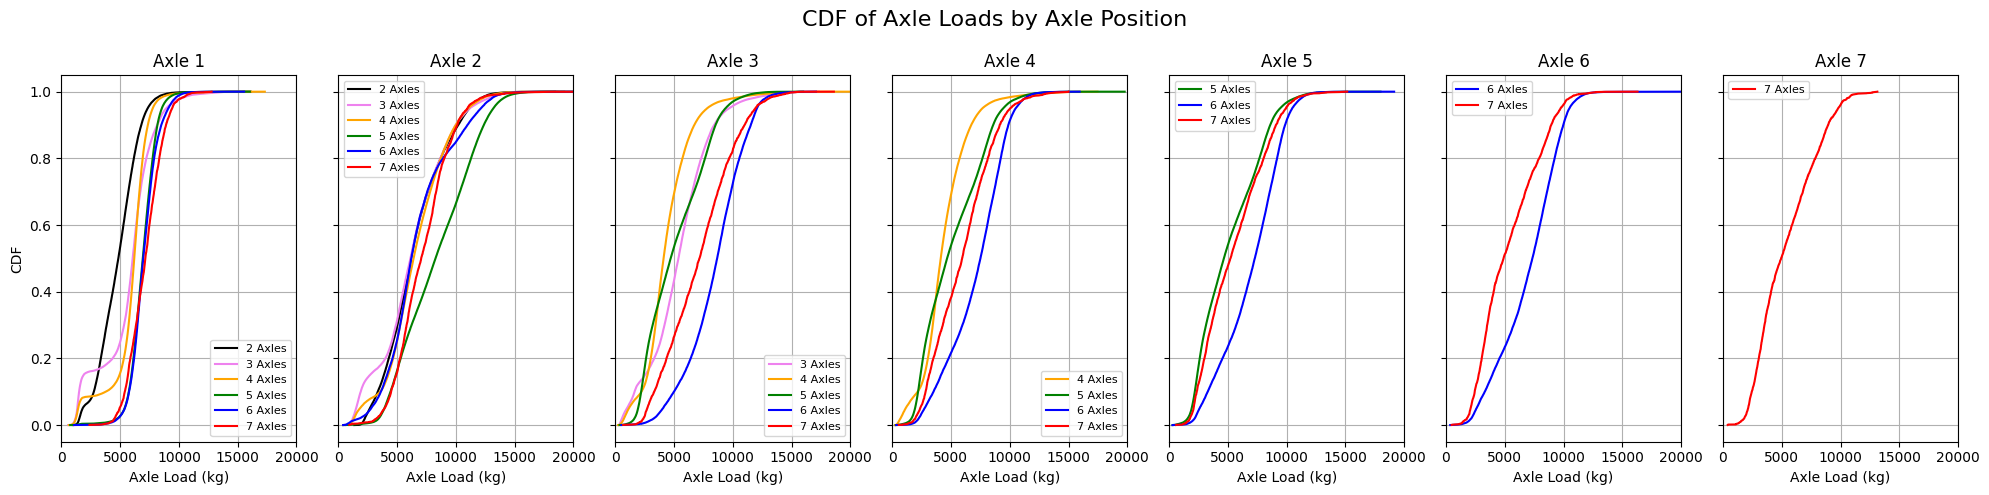

In [24]:
def ecdf(data):
    """Compute ECDF"""
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n + 1) / n
    return x, y

# List of datasets and their labels
datasets = [data2, data3, data4, data5, data6, data7]
labels = ['2 Axles', '3 Axles', '4 Axles', '5 Axles', '6 Axles', '7 Axles']

# Colors for different datasets
colors = ['black', 'violet', 'orange', 'green', 'blue', 'red']

# Number of axle columns to plot
max_axles = max([len(data.columns) for data in datasets])

# Create subplots
fig, axes = plt.subplots(1, max_axles, figsize=(20, 5), sharey=True)
fig.suptitle('CDF of Axle Loads by Axle Position', fontsize=16)

# Plotting
for axle_idx in range(max_axles):
    ax = axes[axle_idx]
    for dataset, label, color in zip(datasets, labels, colors):
        if f'axle {axle_idx + 1} [kg]' in dataset.columns:
            x, y = ecdf(dataset[f'axle {axle_idx + 1} [kg]'])
            ax.plot(x, y, label=label, color=color)
    ax.set_title(f'Axle {axle_idx + 1}')
    ax.set_xlabel('Axle Load (kg)')
    ax.grid(True)
    ax.set_xlim([0, 20000])
    ax.legend(fontsize=8)

# Adjust layout
axes[0].set_ylabel('CDF')
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust space for the main title
plt.savefig("WIM_cdf.png", dpi=300, bbox_inches='tight')
plt.show()


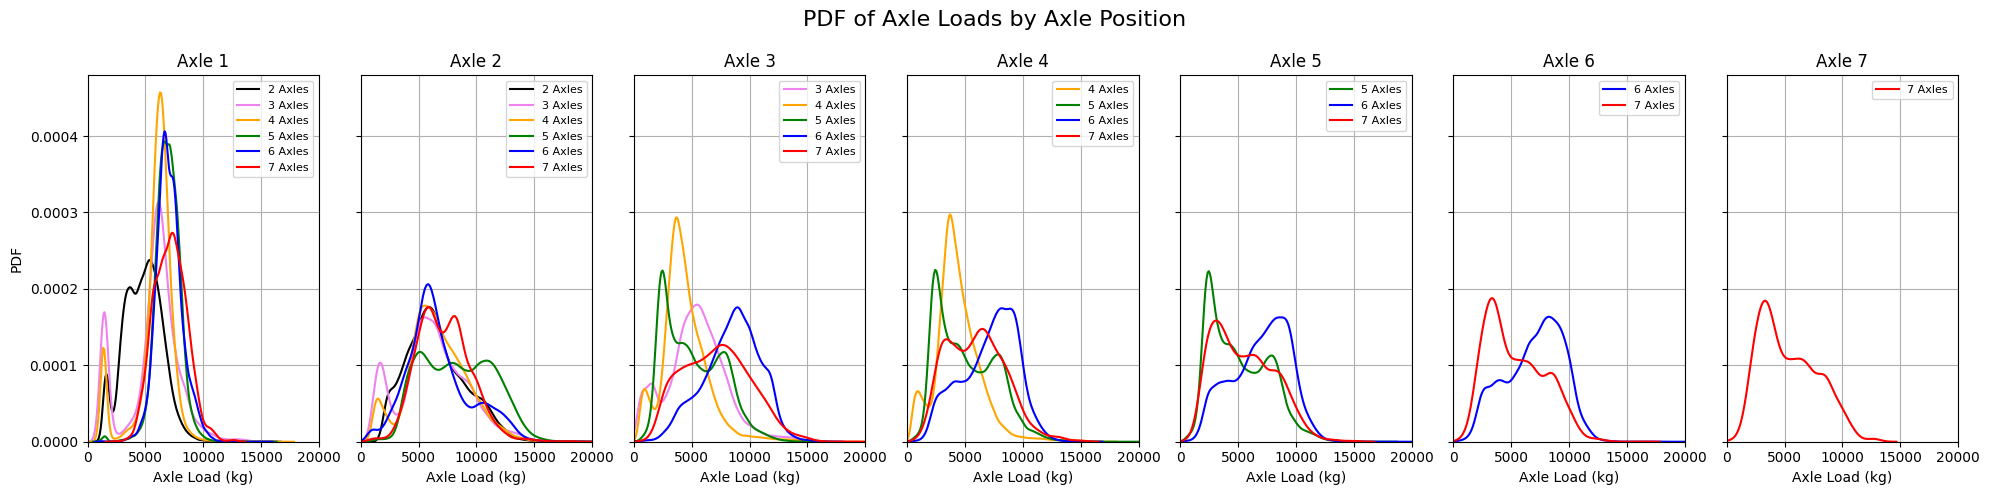

In [25]:
# List of datasets and their labels
datasets = [data2, data3, data4, data5, data6, data7]
labels = ['2 Axles', '3 Axles', '4 Axles', '5 Axles', '6 Axles', '7 Axles']

# Colors for different datasets
colors = ['black', 'violet', 'orange', 'green', 'blue', 'red']

# Number of axle columns to plot
max_axles = max([len(data.columns) for data in datasets])

# Create subplots
fig, axes = plt.subplots(1, max_axles, figsize=(20, 5), sharey=True)
fig.suptitle('PDF of Axle Loads by Axle Position', fontsize=16)

# Plotting
for axle_idx in range(max_axles):
    ax = axes[axle_idx]
    for dataset, label, color in zip(datasets, labels, colors):
        if f'axle {axle_idx + 1} [kg]' in dataset.columns:
            # Plot the PDF using Seaborn's kdeplot
            sns.kdeplot(dataset[f'axle {axle_idx + 1} [kg]'], ax=ax, label=label, color=color, fill=False)
    ax.set_title(f'Axle {axle_idx + 1}')
    ax.set_xlabel('Axle Load (kg)')
    ax.grid(True)
    ax.set_xlim([0, 20000])  # You can adjust the range as necessary
    ax.legend(fontsize=8)

# Adjust layout
axes[0].set_ylabel('PDF')
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust space for the main title
plt.savefig("WIM_pdf.png", dpi=300, bbox_inches='tight')
plt.show()


In [26]:
#sns.pairplot(unity_data7, kind='scatter', height=2)
#plt.show()

In [27]:
#sns.pairplot(sd_data7, height=2,plot_kws=dict(size=.1))
#plt.show()

In [28]:
#Calculate the rank correlation matrix
R_e = data3.corr(method='spearman').values

#Transform data to standard normal and store it in a DataFrame\
unity_data = unity_data3

standard_data = pd.DataFrame(data=stats.norm.ppf(unity_data), columns=unity_data.columns)

#Compute pearson correlation matrix
rho_N = np.corrcoef(standard_data, rowvar=False)

#Transform to rank correlation matrix
R_N = (6 / np.pi) * np.arcsin(rho_N / 2)

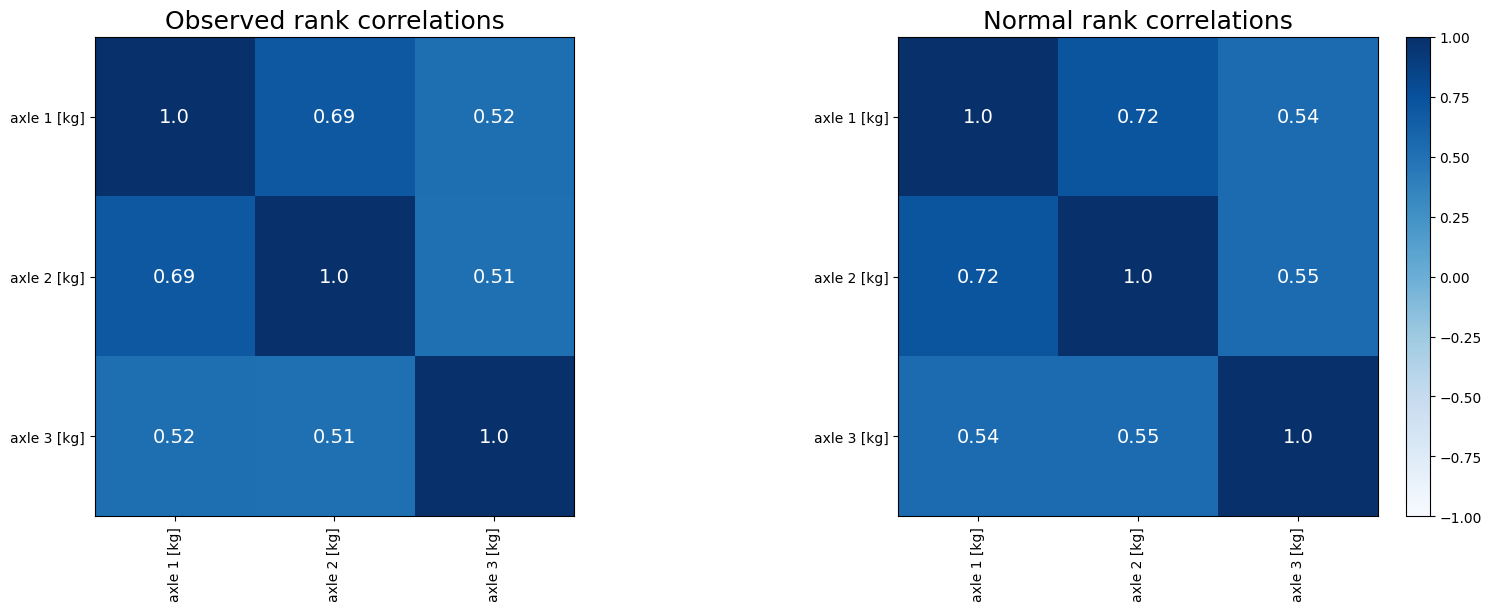

In [29]:
#Plot
nam = unity_data.columns
px = list(range(len(nam)))

fig, axes = plt.subplots(1,2, figsize=(15,6), layout='constrained')
im1=axes[0].imshow(R_e, cmap='Blues', vmin=-1, vmax=1)
axes[0].set_xticks(px, nam, rotation=90)
axes[0].set_yticks(px, nam)
axes[0].set_title('Observed rank correlations',fontsize=18)
zz2 = np.round(R_e, 2)
zz = zz2.astype(str)
for i in range(len(nam)):
    for j in range(len(nam)):
        if zz2[i,j]>0.5:
            color = 'w'
        else:
            color = 'k'
        axes[0].text(j, i, zz[i, j],
                        ha="center", va="center",
                        fontsize=14, color=color)

im1=axes[1].imshow(R_N, cmap='Blues', vmin=-1, vmax=1)
axes[1].set_xticks(px, nam, rotation=90)
axes[1].set_yticks(px, nam)
axes[1].set_title('Normal rank correlations',fontsize=18)
zz2 = np.round(R_N, 2)
zz = zz2.astype(str)
for i in range(len(nam)):
    for j in range(len(nam)):
        if zz2[i,j]>0.5:
            color = 'w'
        else:
            color = 'k'
        axes[1].text(j, i, zz[i, j],
                        ha="center", va="center",
                        fontsize=14, color=color)
        
cbar = fig.colorbar(im1,ax=axes[1], fraction=0.05, pad=0.04)
#plt.savefig("Rankcorr_2axles.png", dpi=300, bbox_inches='tight')
plt.show()

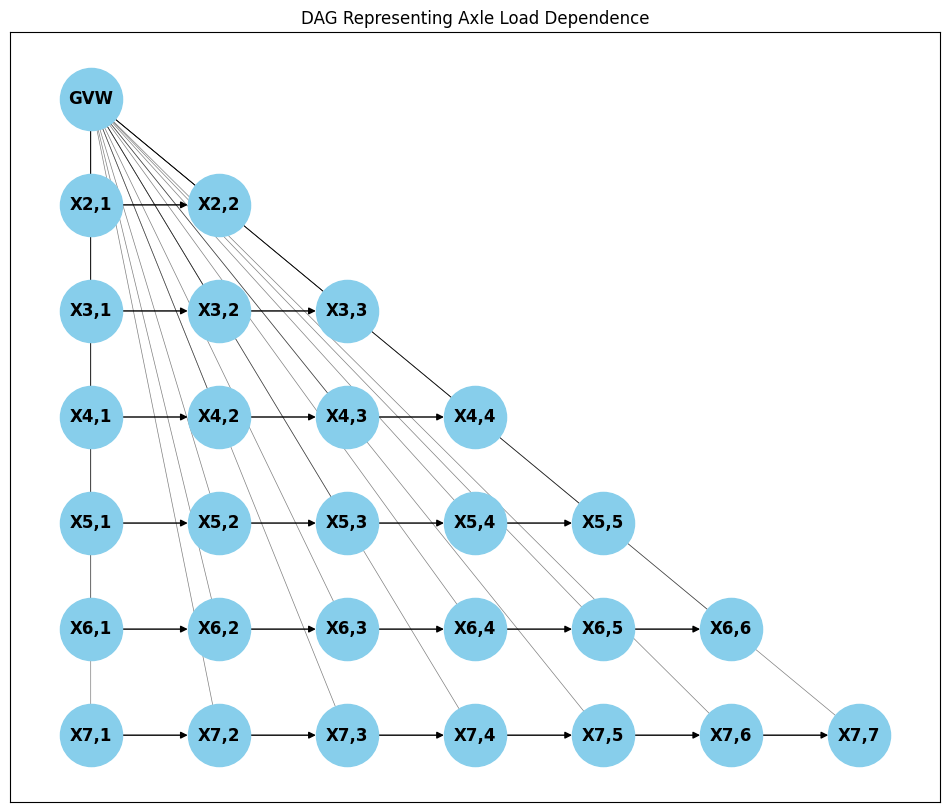

In [30]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes (representing axles)
G.add_nodes_from(["X5,1", "X5,2", "X5,3", "X5,4", "X5,5"])
G.add_nodes_from(["X4,1", "X4,2", "X4,3", "X4,4"])
G.add_nodes_from(["X3,1", "X3,2", "X3,3"])
G.add_nodes_from(["X2,1", "X2,2"])
G.add_nodes_from(["GVW"])
G.add_nodes_from(["X6,1", "X6,2", "X6,3", "X6,4", "X6,5", "X6,6"])
G.add_nodes_from(["X7,1", "X7,2", "X7,3", "X7,4", "X7,5", "X7,6", "X7,7"])

# Add directed edges based on physical understanding and correlations
# Normal edges
normal_edges = [("X5,1", "X5,2"), ("X5,2", "X5,3"), ("X5,3", "X5,4"), ("X5,4", "X5,5"),
                ("X4,1", "X4,2"), ("X4,2", "X4,3"), ("X4,3", "X4,4"),
                ("X3,1", "X3,2"), ("X3,2", "X3,3"),
                ("X2,1", "X2,2"),
                ("X6,1", "X6,2"), ("X6,2", "X6,3"), ("X6,3", "X6,4"), ("X6,4", "X6,5"), ("X6,5", "X6,6"),
                ("X7,1", "X7,2"), ("X7,2", "X7,3"), ("X7,3", "X7,4"), ("X7,4", "X7,5"), ("X7,5", "X7,6"), ("X7,6", "X7,7")]

# Thin edges to GVW
thin_edges = [("X5,1", "GVW"), ("X5,2", "GVW"), ("X5,3", "GVW"), ("X5,4", "GVW"), ("X5,5", "GVW"),
              ("X4,1", "GVW"), ("X4,2", "GVW"), ("X4,3", "GVW"), ("X4,4", "GVW"),
              ("X3,1", "GVW"), ("X3,2", "GVW"), ("X3,3", "GVW"),
              ("X2,1", "GVW"), ("X2,2", "GVW"),
              ("X6,1", "GVW"), ("X6,2", "GVW"), ("X6,3", "GVW"), ("X6,4", "GVW"), ("X6,5", "GVW"), ("X6,6", "GVW"),
              ("X7,1", "GVW"), ("X7,2", "GVW"), ("X7,3", "GVW"), ("X7,4", "GVW"), ("X7,5", "GVW"), ("X7,6", "GVW"), ("X7,7", "GVW")]

G.add_edges_from(normal_edges)
G.add_edges_from(thin_edges)

# Define positions for the nodes
pos = {'X5,1': (0, 2), 'X5,2': (1, 2), 'X5,3': (2, 2), 'X5,4': (3, 2), 'X5,5': (4, 2), 
       'X4,1': (0, 3), 'X4,2': (1, 3), 'X4,3': (2, 3), 'X4,4': (3, 3),
       'X3,1': (0, 4), 'X3,2': (1, 4), 'X3,3': (2, 4),
       'X2,1': (0, 5), 'X2,2': (1, 5),
       'GVW' : (0, 6),
       'X6,1': (0, 1), 'X6,2': (1, 1), 'X6,3': (2, 1), 'X6,4': (3, 1), 'X6,5': (4, 1), 'X6,6': (5, 1),
       'X7,1': (0, 0), 'X7,2': (1, 0), 'X7,3': (2, 0), 'X7,4': (3, 0), 'X7,5': (4, 0), 'X7,6': (5, 0), 'X7,7': (6, 0)}

# Draw edges with arrows and different styles
plt.figure(figsize=(12, 10))

# Draw normal edges with arrows
nx.draw_networkx_edges(
    G, pos, edgelist=normal_edges, width=1, edge_color='black', arrowstyle='-|>', arrowsize=10, node_size=2000
)

# Draw thin edges to GVW with arrows
nx.draw_networkx_edges(
    G, pos, edgelist=thin_edges, width=0.5, alpha=0.5, edge_color='black', arrowstyle='-', arrowsize=5, node_size=2000
)

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Add title and save
plt.title("DAG Representing Axle Load Dependence")
#plt.savefig("DAG.png", dpi=300, bbox_inches='tight')
plt.show()


In [31]:
import warnings  
warnings.filterwarnings("ignore")

plt.figure(figsize=(3,1))
uniform_data = unity_data7.reset_index(drop=True)
variable_names = unity_data7.columns.tolist()
M = cvm_statistic(uniform_data, names=variable_names, plot=True, fig_name='cvm_statistics_plot')
print(M)
plt.savefig("CvM_7axles.png", dpi=300, bbox_inches='tight')
plt.show()


KeyboardInterrupt



<Figure size 300x100 with 0 Axes>

In [32]:
names7 = list(data7.columns)
print(names7)

N = data7.shape[1] # number of nodes
parents7 = [None]*N  # create an empty list 

parents7[0] = []          
parents7[1] = [0]            
parents7[2] = [1]      
parents7[3] = [2] 
parents7[4] = [3] 
parents7[5] = [4] 
parents7[6] = [5] 

len(parents7)

['axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]', 'axle 4 [kg]', 'axle 5 [kg]', 'axle 6 [kg]', 'axle 7 [kg]']


7

In [33]:
names6 = list(data6.columns)
print(names6)

N = data6.shape[1] # number of nodes
parents6 = [None]*N  # create an empty list 

parents6[0] = []          
parents6[1] = [0]            
parents6[2] = [1]      
parents6[3] = [2] 
parents6[4] = [3] 
parents6[5] = [4] 

len(parents6)

['axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]', 'axle 4 [kg]', 'axle 5 [kg]', 'axle 6 [kg]']


6

In [34]:
names5 = list(data5.columns)
print(names5)

N = data5.shape[1] # number of nodes
parents5 = [None]*N  # create an empty list 

parents5[0] = []          
parents5[1] = [0]            
parents5[2] = [1]      
parents5[3] = [2] 
parents5[4] = [3] 

len(parents5)

['axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]', 'axle 4 [kg]', 'axle 5 [kg]']


5

In [35]:
names4 = list(data4.columns)
print(names4)

N = data4.shape[1] # number of nodes
parents4 = [None]*N  # create an empty list 

parents4[0] = []          
parents4[1] = [0]            
parents4[2] = [1]      
parents4[3] = [2] 

len(parents4)

['axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]', 'axle 4 [kg]']


4

In [36]:
names3 = list(data3.columns)
print(names3)

N = data3.shape[1] # number of nodes
parents3 = [None]*N  # create an empty list 

parents3[0] = []          
parents3[1] = [0]            
parents3[2] = [1]      

len(parents3)

['axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]']


3

In [37]:
names2 = list(data2.columns)
print(names2)

N = data2.shape[1] # number of nodes
parents2 = [None]*N  # create an empty list 

parents2[0] = []          
parents2[1] = [0]                  

len(parents2)

['axle 1 [kg]', 'axle 2 [kg]']


2

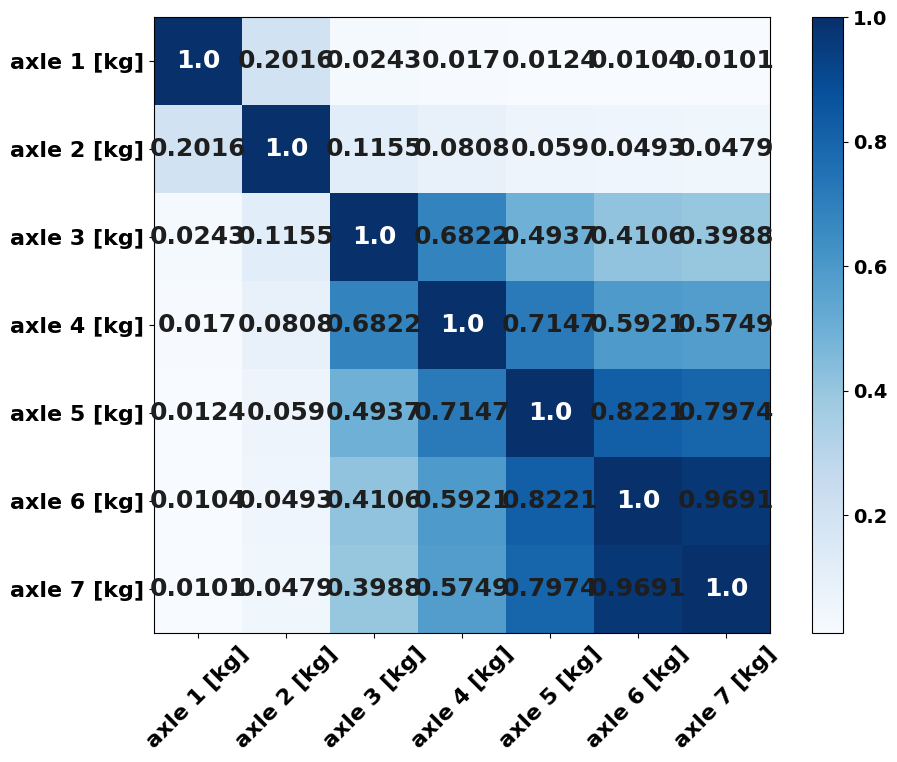

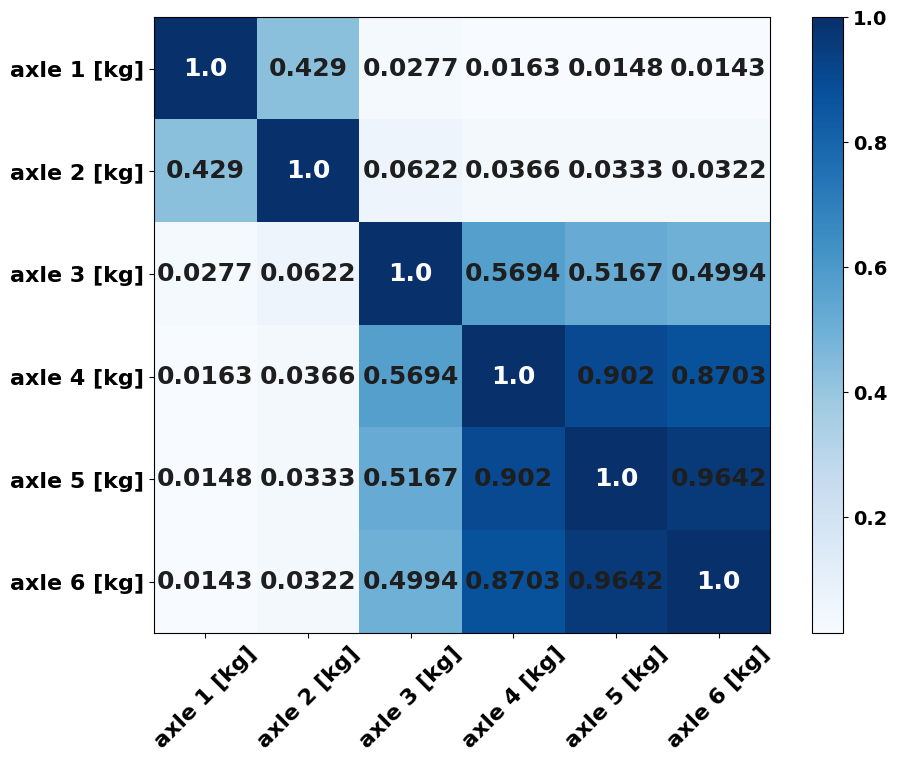

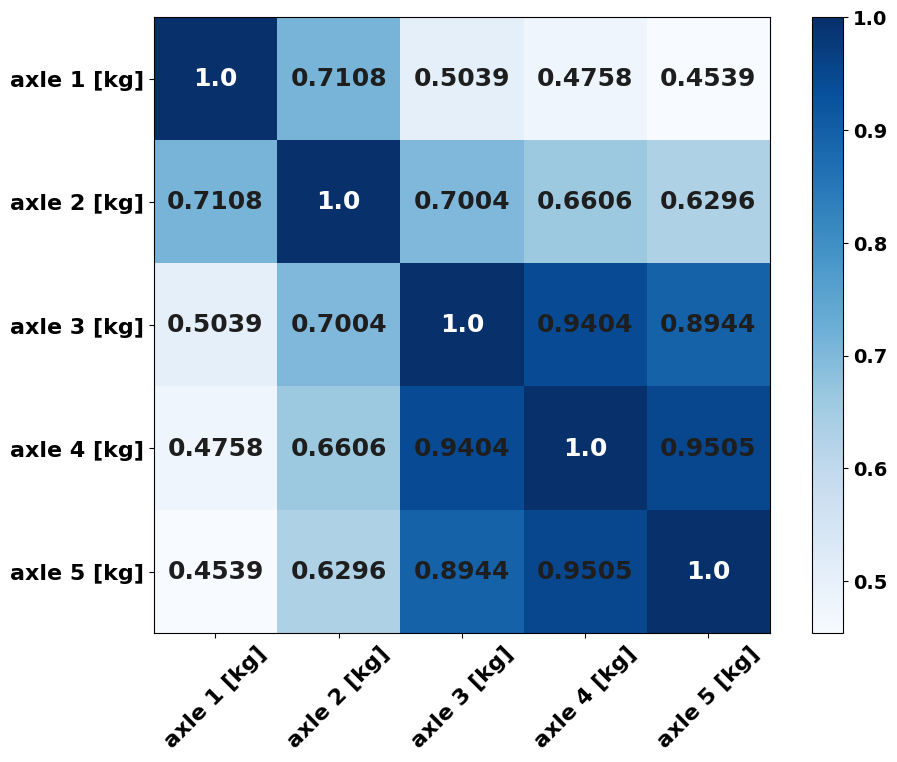

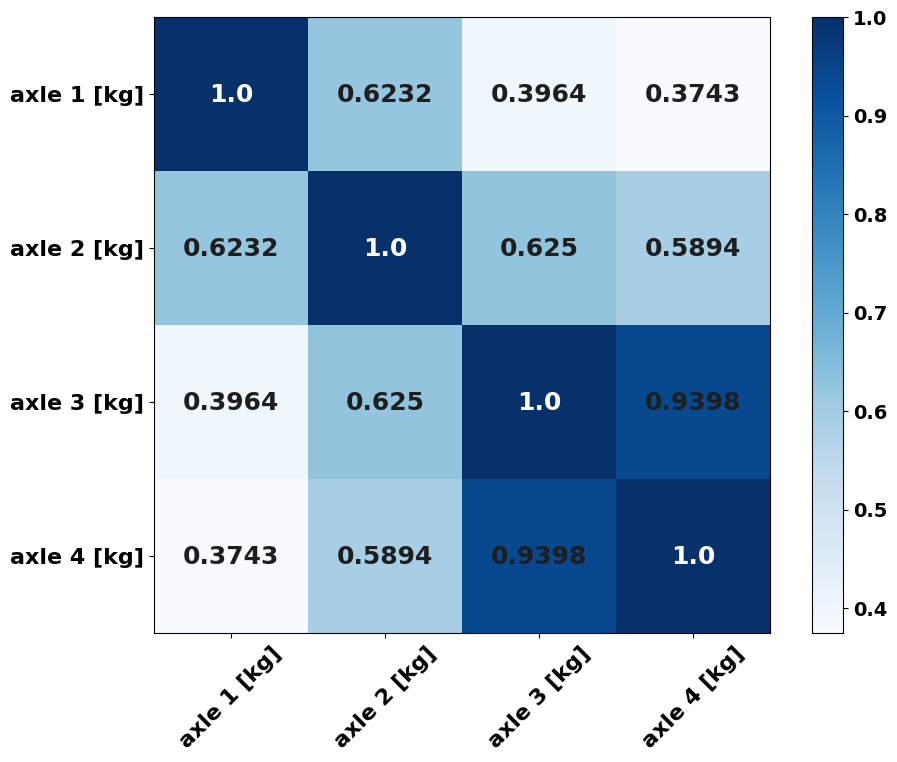

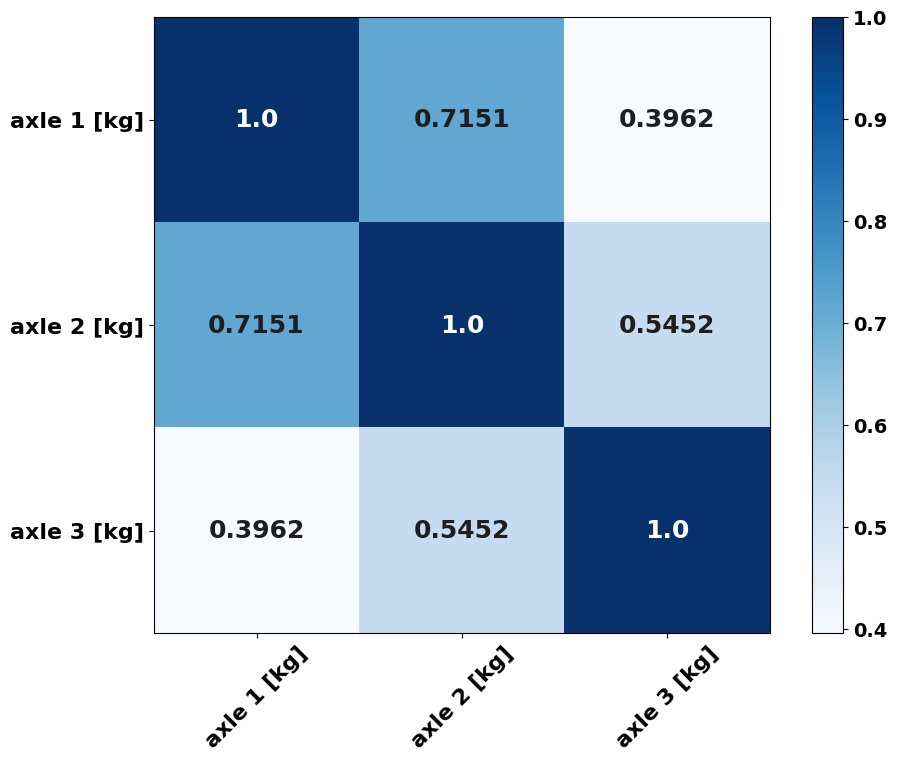

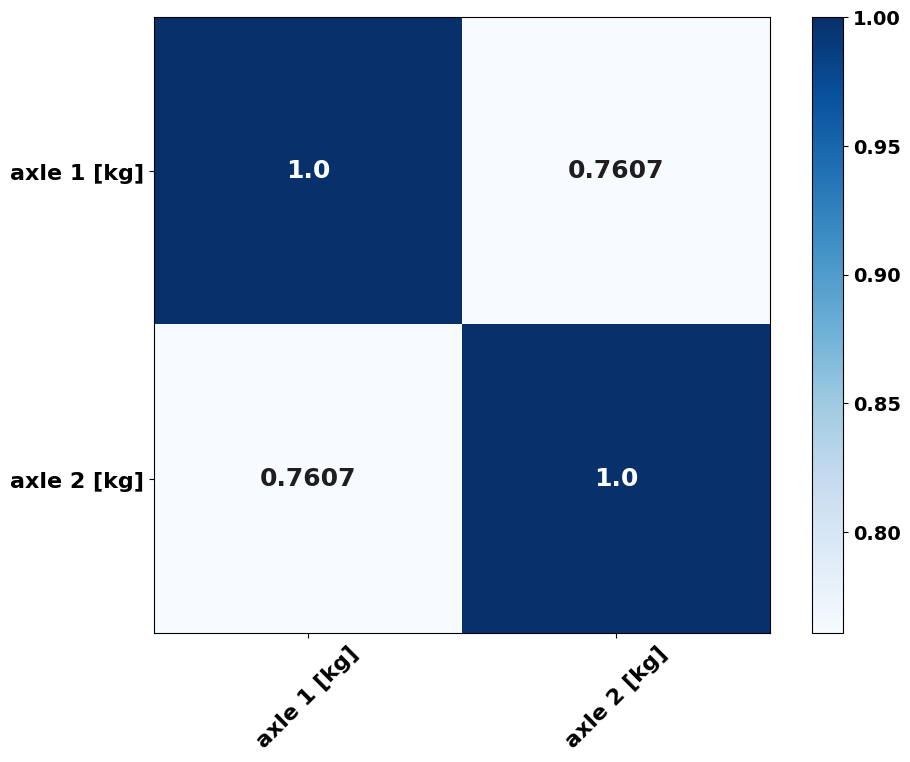

In [38]:
R_BN_7= bn_rankcorr(parents7, data7, var_names=names7, is_data=True, plot=True)
R_BN_6= bn_rankcorr(parents6, data6, var_names=names6, is_data=True, plot=True)
R_BN_5= bn_rankcorr(parents5, data5, var_names=names5, is_data=True, plot=True)
R_BN_4= bn_rankcorr(parents4, data4, var_names=names4, is_data=True, plot=True)
R_BN_3= bn_rankcorr(parents3, data3, var_names=names3, is_data=True, plot=True)
R_BN_2= bn_rankcorr(parents2, data2, var_names=names2, is_data=True, plot=True)

In [39]:
counts2023 = pd.read_csv('counts_filtered_2023.csv', delimiter=',', skipinitialspace=True, index_col=False);

In [40]:
# Axle distribution
axle_distribution = {
    'buses_and_coaches': {2: 0.573, 3: 0.427},
    'HGVs_2_rigid_axle': {2: 1.0},
    'HGVs_3_rigid_axle': {3: 1.0},
    'HGVs_4_or_more_rigid_axle': {4: 0.531, 5: 0.328, 6: 0.115, 7: 0.027},
    'HGVs_3_or_4_articulated_axle': {3: 0.176, 4: 0.824},
    'HGVs_5_articulated_axle': {5: 1.0},
    'HGVs_6_articulated_axle': {3: 0.038, 4: 0.962}
}

# Initialize axle columns
counts2023['2_axle'] = 0
counts2023['3_axle'] = 0
counts2023['4_axle'] = 0
counts2023['5_axle'] = 0
counts2023['6_axle'] = 0
counts2023['7_axle'] = 0

# Apply distributions
for category, distribution in axle_distribution.items():
    for axle, ratio in distribution.items():
        counts2023[f'{axle}_axle'] += (counts2023[category] * ratio).round().astype(int)

# Drop original vehicle classification columns
counts2023 = counts2023.drop(columns=list(axle_distribution.keys()), inplace=False)

# Display final DataFrame
display(counts2023)

,year,road_name,road_category,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,direction_of_travel,all_HGVs,2_axle,3_axle,4_axle,5_axle,6_axle,7_axle
0,2023,M80,TM,A73,A73,274293,674066,55.943145,-4.014292,E,2983,541,223,2070,155,23,5
1,2023,M80,TM,A73,A73,274293,674066,55.943145,-4.014292,W,3293,724,347,1751,485,22,5
2,2023,M74,TM,A74,A724,263553,662467,55.836076,-4.180268,E,4079,1015,301,1564,1246,24,6
3,2023,M74,TM,A74,A724,263553,662467,55.836076,-4.180268,W,4088,1017,302,1567,1249,24,6
4,2023,M4,TM,28,27,328415,187298,51.579978,-3.034482,N,4154,893,448,1841,1154,18,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,2023,M5,TM,18,18A,353517,178492,51.503440,-2.671087,E,3221,523,277,1783,729,12,3
2006,2023,M5,TM,18,18A,353517,178492,51.503440,-2.671087,W,2943,604,260,1414,772,14,3
2007,2023,M5,TM,11A,11,389197,218974,51.869235,-2.158306,N,5371,837,425,3561,623,21,5
2008,2023,M5,TM,11A,11,389197,218974,51.869235,-2.158306,S,5307,941,459,3325,680,23,6


In [50]:
array = []
# Iterate over rows in the dataframe
for i in range(len(counts2023)):
    
    # Generate samples for each axle type
    a = generate_samples(R_BN_2, counts2023.iloc[i]['2_axle'], names=names2, data=data2)
    b = generate_samples(R_BN_3, counts2023.iloc[i]['3_axle'], names=names3, data=data3)
    c = generate_samples(R_BN_4, counts2023.iloc[i]['4_axle'], names=names4, data=data4)
    d = generate_samples(R_BN_5, counts2023.iloc[i]['5_axle'], names=names5, data=data5)
    e = generate_samples(R_BN_6, counts2023.iloc[i]['6_axle'], names=names6, data=data6)
    f = generate_samples(R_BN_7, counts2023.iloc[i]['7_axle'], names=names7, data=data7)
    
    # Concatenate all axle type samples for this row
    combined_row_df = pd.concat([a, b, c, d, e, f], ignore_index=True)
    array.append(combined_row_df)     

KeyboardInterrupt: 

In [51]:
len(array)

1892

In [75]:
array[1000]

,axle 1 [kg],axle 2 [kg],axle 3 [kg],axle 4 [kg],axle 5 [kg],axle 6 [kg],axle 7 [kg]
0,4614.0,4133.0,NaN,NaN,NaN,NaN,NaN
1,3431.0,4087.0,NaN,NaN,NaN,NaN,NaN
2,6219.0,10932.0,NaN,NaN,NaN,NaN,NaN
3,5174.0,4389.0,NaN,NaN,NaN,NaN,NaN
4,1524.0,2669.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2630,4766.0,6239.0,7849.0,7440.0,8428.0,10463.0,9993.0
2631,7832.0,3270.0,6018.0,3997.0,3676.0,3197.0,3402.0
2632,6493.0,3086.0,8648.0,7440.0,8156.0,7221.0,8037.0
2633,6412.0,4150.0,4279.0,4656.0,3929.0,2657.0,2658.0


In [72]:
np.sum([counts2023.iloc[1000]['2_axle'],
        counts2023.iloc[1000]['3_axle'],
        counts2023.iloc[1000]['4_axle'],
        counts2023.iloc[1000]['5_axle'],
        counts2023.iloc[1000]['6_axle'],
        counts2023.iloc[1000]['7_axle']])

2635